### setup

In [7]:
!test -d big_vision || (git clone https://github.com/andsteing/big_vision && cd big_vision && git checkout -b origin/torch)

In [16]:
!pip install -q einops flax ml_collections tensorflow_addons tensorflow_text

     |████████████████████████████████| 578.0 MB 12 kB/s 
     |████████████████████████████████| 1.7 MB 49.1 MB/s 
     |████████████████████████████████| 5.9 MB 45.3 MB/s 
     |████████████████████████████████| 438 kB 52.6 MB/s 
     |████████████████████████████████| 85 kB 3.8 MB/s 


In [9]:
import sys
if 'big_vision' not in sys.path: sys.path.insert(0, 'big_vision')

In [10]:
from google.colab import auth
auth.authenticate_user()

### fetch params

In [ ]:
from tensorflow.io import gfile
gfile.copy('gs://big_vision_eu/lit_private/lit_jft_b32b/checkpoint.npz', 'lit_jft_b32b.npz', overwrite=True)

In [ ]:
from big_vision import utils
params = utils.load_params(None, 'lit_jft_b32b.npz')

In [22]:
darams = D(params)  # for TAB completion

### helper code

In [ ]:
# some utilities

class LoggingDict(dict):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.accessed = {}

  def __getitem__(self, k):
    self.accessed[k] = self.accessed.get(k, 0) + 1
    return super().__getitem__(k)


from typing import Mapping
class D(dict):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    for k, v in self.items():
      while hasattr(self, k):
        k += '_'
      if isinstance(v, Mapping):
        v = D(v)
      setattr(self, k, v)

In [27]:
# some helper code to verify results are ~identical

import flax
import matplotlib.pyplot as plt
import numpy as np
import torch

inputs_ident = lambda x: torch.from_numpy(x)
inputs_image_transpose = lambda x: inputs_ident(x).permute(0, 3, 1, 2)
inputs_long = lambda x: inputs_ident(x).type(torch.long)
outputs_ident = lambda x: x.detach().numpy()
inputs_ones = lambda dtype=np.float32: lambda shape: np.ones(shape, dtype=dtype)
inputs_normal = lambda shape: np.random.normal(size=shape).astype(np.float32)
inputs_randint = lambda max_val: lambda shape: np.random.uniform(0, max_val, size=shape).astype(dtype=np.int32)

def hist(targets, outputs):
  """Shows diffs as histogram."""
  plt.figure()
  plt.hist((targets - outputs).flatten())


def cmp(
    flaxmod, torchmod, params, inputs_shape,
    *,
    inputs_generator=inputs_ones(),
    inputs_transform=inputs_ident,
    outputs_transform=outputs_ident,
    visualdiff=hist,
    reldiff=False,
):
  """Runs inputs through flaxmod/torchmod & diffs outputs."""
  if not isinstance(inputs_shape, tuple):
    inputs_shape = (inputs_shape,)
  if not isinstance(inputs_generator, tuple):
    inputs_generator = (inputs_generator,) * len(inputs_shape)
  if not isinstance(inputs_transform, tuple):
    inputs_transform = (inputs_transform,) * len(inputs_shape)
  assert len(inputs_shape) == len(inputs_generator) == len(inputs_transform)

  inputs = [ig(shape) for ig, shape in zip(inputs_generator, inputs_shape)]
  targets = flaxmod.apply({'params': params}, *inputs)
  # targets = targets[1]['encoded']
  if not isinstance(targets, tuple):
    targets = (targets,)
  if isinstance(targets[-1], dict):
    targets = targets[:-1]
  targets = tuple(np.array(t) for t in targets)

  w = LoggingDict(flax.traverse_util.flatten_dict(params, sep='/'))
  torchmod.load(w)
  unused = set(w).difference(w.accessed)
  assert not unused, unused
  overused = {k: v for k, v in w.accessed.items() if v > 1}
  assert not overused, overused
  inputs_ = [it(inp) for it, inp in zip(inputs_transform, inputs)]
  outputs_ = torchmod(*inputs_)
  if not isinstance(outputs_, tuple):
    outputs_ = (outputs_,)
  if not isinstance(outputs_transform, tuple):
    outputs_transform = (outputs_transform,) * len(outputs_)
  outputs = tuple(ot(o) for ot, o in zip(outputs_transform, outputs_))

  assert len(targets) == len(outputs), (len(targets), len(outputs))
  means, stds = [], []
  for i, (t, o) in enumerate(zip(targets, outputs)):
    assert t.shape == o.shape, (i, t.shape, o.shape)
    visualdiff(t, o)
    d = (t - o).flatten()
    if reldiff: d /= t.flatten()
    means += [d.mean()]
    stds += [d.std()]
  return [t.shape for t in targets], means, stds


### compare implementations

In [ ]:
# what we want to compare

from big_vision.tools import torch as bv_torch
from big_vision.models import vit
from big_vision.models.proj.image_text import text_transformer, two_towers


([(1, 2, 768)], [-6.703467e-06], [0.00036685242])

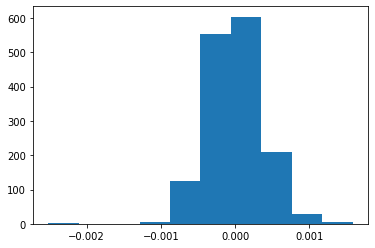

In [28]:
flaxmod = vit.MlpBlock()
torchmod = bv_torch.MlpBlock()
cmp(flaxmod, torchmod, darams.img.Transformer.encoderblock_0.MlpBlock_0, [1, 2, 768], visualdiff=hist)

big_vision/big_vision/tools/torch.py:85: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)
  getattr(self, kqv).bias.copy_(_n2p(w[f'{prefix}{kqv}/bias'], t=False).flatten().T)


([(1, 2, 768)], [1.6986329e-09], [8.438751e-08])

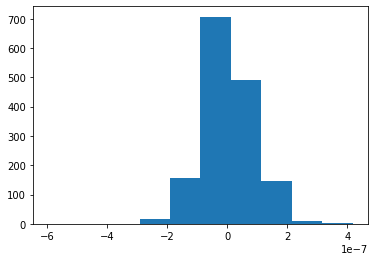

In [29]:
flaxmod = flax.linen.MultiHeadDotProductAttention(num_heads=12)
torchmod = bv_torch.MultiHeadDotProductAttention()
p = darams.img.Transformer.encoderblock_0.MultiHeadDotProductAttention_0
cmp(flaxmod, torchmod, p, ([1, 2, 768], [1, 3, 768]), inputs_generator=inputs_normal)

([(1, 2, 768)], [8.656391e-06], [0.0019266398])

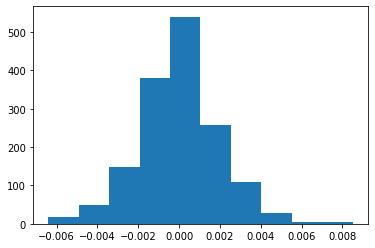

In [30]:
flaxmod = vit.Encoder1DBlock()
torchmod = bv_torch.Encoder1DBlock()
p = darams.img.Transformer.encoderblock_0
cmp(flaxmod, torchmod, p, [1, 2, 768])

([(1, 2, 768)], [3.1225714e-05], [0.028721781])

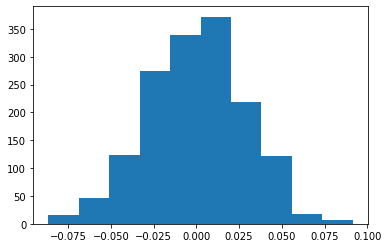

In [31]:
flaxmod = vit.Encoder(12)
torchmod = bv_torch.Encoder(12)
p = darams.img.Transformer
cmp(flaxmod, torchmod, p, [1, 2, 768])

([(1, 768)], [-2.2414606e-06], [0.00016751807])

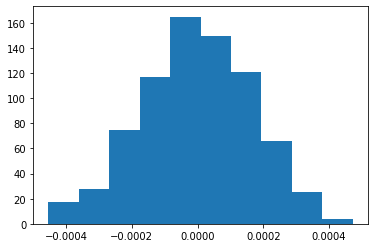

In [32]:
flaxmod = vit.MAPHead()
torchmod = bv_torch.MAPHead()
p = darams.img.MAPHead_0
cmp(flaxmod, torchmod, p, [1, 2, 768])

([(1, 768)], [-2.2414606e-06], [0.00016751807])

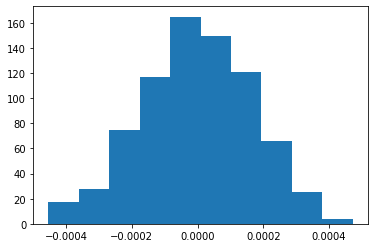

In [33]:
flaxmod = vit.MAPHead()
torchmod = bv_torch.MAPHead()
p = darams.img.MAPHead_0
cmp(flaxmod, torchmod, p, [1, 2, 768])

([(1, 768)], [0.0005097343], [0.047091104])

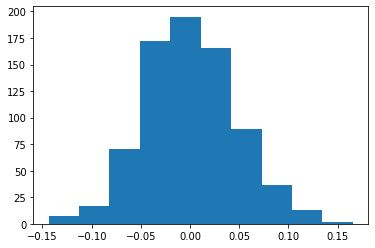

In [35]:
flaxmod = vit.Model(None, variant='B/32', pool_type='map_buggy')
torchmod = bv_torch.ViT(0, **bv_torch._IMAGE_VARIANTS['B/32'], pool_type='map_buggy')
p = darams.img
cmp(flaxmod, torchmod, p, [1, 224, 244, 3],
    inputs_generator=inputs_normal,
    inputs_transform=inputs_image_transpose)

([(1, 768)], [-0.00016547808], [0.007839344])

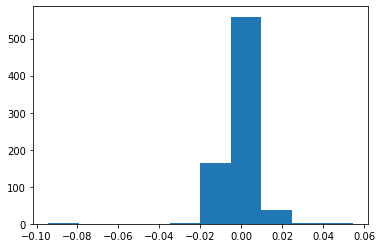

In [36]:
flaxmod = text_transformer.Model(768, variant='B')
torchmod = bv_torch.TextTransformer(768, width=768, depth=12, num_heads=12, mlp_dim=4*768)
p = darams.txt
cmp(flaxmod, torchmod, p, [1, 16], inputs_generator=inputs_randint(32_000), inputs_transform=inputs_long)

([(2, 768), (2, 768)],
 [-2.0245004e-06, 3.8465214e-07],
 [0.000103778126, 9.317586e-05])

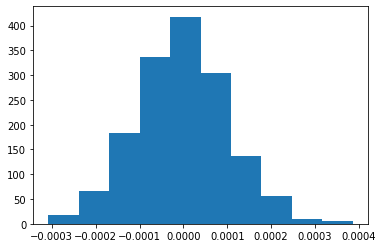

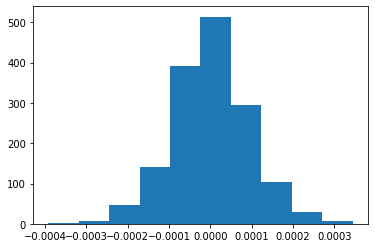

In [39]:
import ml_collections
kw = dict(image=dict(variant='B/32', pool_type='map_buggy'), text=dict(variant='B'), out_dim=[0, 768])
flaxmod = two_towers.Model(**ml_collections.ConfigDict(kw))  # conversion required !!
torchmod = bv_torch.TwoTowers(**kw)
p = darams
cmp(flaxmod, torchmod, p, ([2, 224, 224, 3], [2, 16]),
    inputs_generator=(inputs_normal, inputs_randint(32_000)),
    inputs_transform=(inputs_image_transpose, inputs_long))